# Using 20 monkeys to replicate the standard measures flight data 

In [11]:
### Using monkey_env/ ###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx

#fix the error that pops up about ipwydgets 
from tqdm import tqdm

#from .autonotebook import tqdm as notebook_tqdm

print("Setup Complete")


Setup Complete


In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Data Loading

In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')

In [8]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
twenty_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
twenty_df.set_index(['ID'])

twenty_df['ID'] = twenty_df['ID'].astype(str)


#twenty_dff.columns
twenty_df.tail()

Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
504,1880,Rhesus-Chinese,2017-12-18,No,NaT,2007-10-25,M,Research,NaN,NaN,...,19.2,3.6,0.5,0.0,3221,806,151,21,0,150
505,1880,Rhesus-Chinese,2018-04-16,No,NaT,2007-10-25,M,Research,NaN,NaN,...,13.7,7.2,0.2,0.1,7644,1329,698,19,10,213
506,1880,Rhesus-Chinese,2018-04-26,No,NaT,2007-10-25,M,Clinical,NaN,NaN,...,10.4,4.3,0.1,0.0,11928,1456,602,14,0,277
507,1880,Rhesus-Chinese,2018-06-29,No,NaT,2007-10-25,M,Clinical,NaN,NaN,...,13.3,6.8,0.1,0.0,8060,1343,687,10,0,167
508,1880,Rhesus-Chinese,2018-07-12,No,NaT,2007-10-25,M,Research,NaN,NaN,...,10.5,7.4,0.1,0.0,10496,1344,947,13,0,271


# Data processing

In [9]:
#make a parent df
twenty_df.copy()
test_twenty_df = twenty_df
#sreg_df.tail(2)

#make train/testdf
(twenty_train_df, twenty_test_df)= test_twenty_df, test_twenty_df

#mreg_test_df.tail(2)

# label values extraction
twenty_y=twenty_train_df['LYMPHOCYTES_(%)']
twenty_X=twenty_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)

#twenty_y.tail()
#twenty_X.columns

#twenty_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,twenty_X[twenty_X.columns[:4]].shape[1]))


print(cat_features)

# all of our labels are catagorical

[0, 1, 2, 3]


In [12]:

#put the data into the pool
twenty_pool = Pool(data=twenty_X, label=twenty_y, cat_features=cat_features)


#train tesr split - 30% test
twenty_data= train_test_split(twenty_X, twenty_y, test_size=0.3, random_state=0)

#### The order of this matters###
twenty_X_train, twenty_X_validation, twenty_y_train, twenty_y_validation= twenty_data

twenty_train_pool = Pool(
    data = twenty_X_train,
    label = twenty_y_train,
    cat_features = cat_features
)

twenty_validation_pool = Pool(
    data = twenty_X_validation,
    label = twenty_y_validation,
    cat_features = cat_features
)


# Model Formation

In [21]:
# Model for predicting lymphocyte counts
twenty_model= CatBoostRegressor(iterations=10,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
                        
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


twenty_model.fit(twenty_X, 
           twenty_y, 
           cat_features=cat_features,
           #plot=True,
           verbose=100 #tells how many iterations to print
         )

0:	learn: 9.3828470	total: 6.12ms	remaining: 55.1ms
9:	learn: 1.8437993	total: 50.4ms	remaining: 0us


iteritems is deprecated and will be removed in a future version. Use .items instead.


# Prediction

153


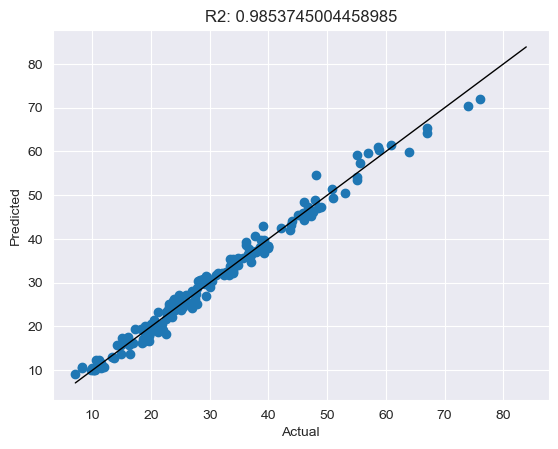

In [28]:
from sklearn.linear_model import LinearRegression
twenty_a = twenty_model.predict(twenty_X_validation)
print(len(twenty_a), 
     )
twenty_a_df = pd.DataFrame(twenty_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(twenty_y_validation, twenty_a_df)


ax.plot([twenty_y.min(), twenty_y.max()], [twenty_y.min(), twenty_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#twenty_y_validation, twenty_a_df = twenty_y_validation.reshape(-1,1), twenty_a_df.reshape(-1,1)
#ax.plot(twenty_y_validation, LinearRegression().fit(twenty_y_validation, twenty_a_df).predict(twenty_y_validation))



ax.set_title('R2: ' + str(r2_score(twenty_y_validation, twenty_a_df)))

plt.show()


In [18]:
# Find the feature importance for predicting the lmphocyte counts
twenty_model.get_feature_importance(data=twenty_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)


,Feature Id,Importances
0,NEUT_(%),87.125459
1,ABS_MONO_(/uL),3.096692
2,ABS_LYMPH_(/uL),2.521308
3,WBC_(K/uL),2.188616
4,Mean_corpuscular_hemaglobin_concentration_(MCH...,1.804904
5,EOS_(%),1.376121
6,BASO_(%),0.582629
7,PLATLET_COUNT_(K/uL),0.522609
8,Hemocrit_(HCT_%),0.392079
9,SEX,0.322865


# Conclusions

The model still performs well with a smaller sample size (20) which is a little concerning but still exciting. I'm wondering how it would run with unrelated data. If it works well, this could drastically reduce the data needed for accurate predictions in real life. The most important features stay the same, which is very promising.